# Прогнозирование стоимости автомобиля по характеристикам
[Ссылка на учебное соревнование SkillFactory](https://www.kaggle.com/c/sf-dst-car-price/)
### Какой кейс решаем?
* Была поставлена задача создать модель, которая будет предсказывать стоимость автомобиля по его характеристикам. 
* Бизнес-кейс является аналогом существующего [сервиса оценки стоимости автомобиля на сайте Auto.ru](https://auto.ru/cars/evaluation/).

### Какая метрика использовалась для оценки качества модели?

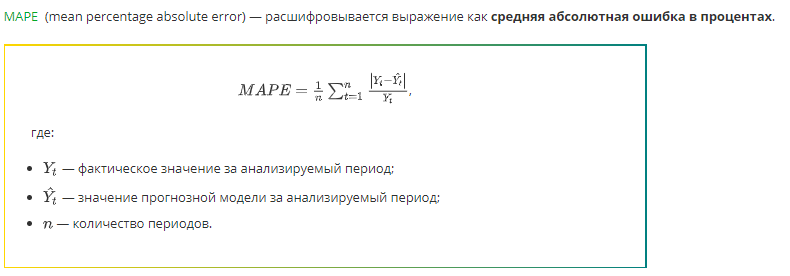

### Какие данные были использованы?
* Первым этапом решения кейса являлось получение необходимых для моделирования данных (в задаче изначально был доступен лишь небольшой датасет с историей продаж, который можно было использовать для тестирования модели).
* Данные были получены парсингом объявлений с сайта auto.ru
* [Cсылка на github с кодом парсера](https://github.com/KristinaLifirenko/autoru_kaggle_competition) и [полученный в ходе парсинга сайта датасет ](https://www.kaggle.com/kristinalifirenko/train-full)

## Импорт библиотек и начальные настройки для работы

In [1]:
import numpy as np # linear algebra
import scipy #for some statistics
from scipy.stats import norm, skew
from scipy.special import boxcox1p
from scipy.special import inv_boxcox1p

import pandas as pd #data processing, CSV file I/O (e.g. pd.read_csv)
from bs4 import BeautifulSoup #data processing
import sys
from tqdm.notebook import tqdm

#data split
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

#models and metrics
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error
import lightgbm as lgb


#vusualization
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
#ignore warning messages
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn

In [3]:
from IPython.display import display
pd.options.display.max_columns = None
pd.options.display.float_format = '{:,.2f}'.format

In [4]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)

Python       : 3.6.6 |Anaconda, Inc.| (default, Oct  9 2018, 12:34:16) 
Numpy        : 1.18.1


In [5]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [6]:
# фиксирую RANDOM_SEED, чтобы эксперименты были воспроизводимы
RANDOM_SEED = 42

In [7]:
VERSION    = 33
DIR_TRAIN  = '../input/train-full/' # подключаю к ноутбуку свой внешний датасет
DIR_TEST   = '../input/sf-dst-car-price/'


# 1. Data Preprocessing

In [8]:
#Загружаем датасеты
train = pd.read_csv(DIR_TRAIN+'train_data.csv')
test = pd.read_csv(DIR_TEST+'test.csv')
sample_submission = pd.read_csv(DIR_TEST+'sample_submission.csv')

In [9]:
train = train.drop_duplicates(keep='first', inplace=False)

In [10]:
#Поскольку собранный датасет содержит в себе данные по разным бренды авто, для обучения буду использовать только те бренды, которые есть в тестовой выборке
df1 = train[(train['brand'] == 'VOLKSWAGEN') | (train['brand'] == 'AUDI')|(train['brand'] == 'BMW')| (train['brand'] == 'TOYOTA')| (train['brand'] == 'MERCEDES')| (train['brand'] == 'SKODA') | (train['brand'] == 'NISSAN')| (train['brand'] == 'MITSUBISHI')| (train['brand'] == 'VOLVO')| (train['brand'] == 'HONDA')| (train['brand'] == 'LEXUS')| (train['brand'] == 'INFINITI')| (train['brand'] == 'SUZUKI')]

train = df1
print('Размер тренировочной выборки:', train.shape)
print('Размер валидационной выборки:', test.shape)
print('Первоначальная пропорция:', round((test.shape[0]/train.shape[0]),2))

Размер тренировочной выборки: (150972, 24)
Размер валидационной выборки: (35990, 23)
Первоначальная пропорция: 0.24


In [11]:
#добавляю два пустых столбца для того, чтобы объединить тренировочную и валидационную выборки
train['id'] = np.nan
test['url'] = np.nan

In [12]:
train['sample'] = 1 # помечаем где у нас трейн
test['sample'] = 0 # помечаем где у нас тест
test['price'] = 0 # в тесте у нас нет значения PRICE, мы его должны предсказать, пока просто заполняем нулями

df = test.append(train, sort=False).reset_index(drop=True) # объединяем данные в один общий датасет для дальнейшей работы

In [13]:
#В объединенном датасете есть поля, в которых отсутствует часть значений. Обозначим их как NaN и в дальнейшем закодируем как отдельное значение поля
df['Привод'].fillna('NaN', inplace = True)
df['Руль'].fillna('NaN', inplace = True)
df['ПТС'].fillna('NaN', inplace = True)
df['Владельцы'].fillna('Nan', inplace = True)
df['description'].fillna('NaN', inplace = True)

In [14]:
#Теперь делаем для этих полей One-Hot-Encoding. С полем description будем работать отдельно в дальнейшем
df = pd.get_dummies(df, columns=["Привод","Руль","ПТС","Владельцы"],prefix=["Привод_is","Руль_is","ПТС_is","Владельцы_is"])

In [15]:
#Приводим текст к нижнему регистру
df['brand'] = df.brand.str.lower()
df['description'] = df.description.str.lower()

In [16]:
#Сразу удаляем поля, которые скорее всего не несут никакой дополнительной информации для модели
df = df.drop(['Состояние','Таможня', 'Владение', 'id'], axis = 1)

Посмотрим внимательнее на датасет и его основные статистики:

In [17]:
df.sample(2)

,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,engineDisplacement,enginePower,description,mileage,Комплектация,url,sample,price,Привод_is_NaN,Привод_is_задний,Привод_is_передний,Привод_is_полный,Руль_is_NaN,Руль_is_Левый,Руль_is_Правый,ПТС_is_NaN,ПТС_is_Дубликат,ПТС_is_Оригинал,Владельцы_is_1 владелец,Владельцы_is_2 владельца,Владельцы_is_3 или более,Владельцы_is_Nan
153057,внедорожник 5 дв.,honda,серый,бензин,2001,1.6 CVT,5,2004,ALLROAD_5_DOORS VARIATOR 1.6,вариатор,1.6 LTR,105 N12,nan,"100,000.00",NaN,NaN,1,"444,000.00",1,0,0,0,1,0,0,1,0,0,0,0,0,1
85698,седан,infiniti,чёрный,бензин,2005,4.5 AT,4,2006,SEDAN AUTOMATIC 4.5,автоматическая,4.5 LTR,340 N12,nan,"98,500.00",NaN,NaN,1,"650,000.00",1,0,0,0,1,0,0,1,0,0,0,0,0,1


In [18]:
df.head()

,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,engineDisplacement,enginePower,description,mileage,Комплектация,url,sample,price,Привод_is_NaN,Привод_is_задний,Привод_is_передний,Привод_is_полный,Руль_is_NaN,Руль_is_Левый,Руль_is_Правый,ПТС_is_NaN,ПТС_is_Дубликат,ПТС_is_Оригинал,Владельцы_is_1 владелец,Владельцы_is_2 владельца,Владельцы_is_3 или более,Владельцы_is_Nan
0,внедорожник 5 дв.,mercedes,синий,бензин,"2,015.00",250 2.0 AT (211 л.с.) 4WD,5.00,"2,017.00",ALLROAD_5_DOORS AUTOMATIC 2.0,автоматическая,2.0 LTR,211 N12,"все автомобили, для вашего удобства, находятся...","50,000.00","['[{""name"":""Безопасность"",""values"":[""Антипробу...",NaN,0,0.00,0,0,0,1,0,1,0,0,0,1,1,0,0,0
1,седан,infiniti,чёрный,бензин,"2,014.00",3.7 AT (333 л.с.) 4WD,4.00,"2,014.00",SEDAN AUTOMATIC 3.7,автоматическая,3.7 LTR,333 N12,дилерская. покупалась в москве на ленинском. я...,"78,000.00",[],NaN,0,0.00,0,0,0,1,0,1,0,0,0,1,0,1,0,0
2,хэтчбек 5 дв.,nissan,белый,бензин,"2,009.00",1.6 AT (110 л.с.),5.00,"2,013.00",HATCHBACK_5_DOORS AUTOMATIC 1.6,автоматическая,1.6 LTR,110 N12,автомобили с пробегом от официального дилера у...,"98,000.00","['[{""name"":""Элементы экстерьера"",""values"":[""Ст...",NaN,0,0.00,0,0,1,0,0,1,0,0,0,1,1,0,0,0
3,внедорожник 5 дв.,bmw,серый,дизель,"2,013.00",M50d 3.0d AT (381 л.с.) 4WD,5.00,"2,016.00",ALLROAD_5_DOORS AUTOMATIC 3.0,автоматическая,3.0 LTR,381 N12,в рольф ясенево представлено более 500 автомоб...,"69,000.00","['[{""name"":""Комфорт"",""values"":[""Круиз-контроль...",NaN,0,0.00,0,0,0,1,0,1,0,0,0,1,0,0,1,0
4,внедорожник 5 дв.,mercedes,чёрный,бензин,"2,013.00",200 1.6 AMT (156 л.с.),5.00,"2,015.00",ALLROAD_5_DOORS ROBOT 1.6,роботизированная,1.6 LTR,156 N12,"оригинал птс, два ключа\n\nпанавто – официальн...","116,473.00","['[{""name"":""Элементы экстерьера"",""values"":[""Ле...",NaN,0,0.00,0,0,1,0,0,1,0,0,0,1,0,1,0,0


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186962 entries, 0 to 186961
Data columns (total 32 columns):
bodyType                    186962 non-null object
brand                       186962 non-null object
color                       186962 non-null object
fuelType                    186962 non-null object
modelDate                   186962 non-null object
name                        186962 non-null object
numberOfDoors               186962 non-null object
productionDate              186962 non-null object
vehicleConfiguration        186962 non-null object
vehicleTransmission         186962 non-null object
engineDisplacement          186962 non-null object
enginePower                 186962 non-null object
description                 186962 non-null object
mileage                     186955 non-null float64
Комплектация                132080 non-null object
url                         96190 non-null object
sample                      186962 non-null int64
price                  

In [20]:
df.describe(include='all')

,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,engineDisplacement,enginePower,description,mileage,Комплектация,url,sample,price,Привод_is_NaN,Привод_is_задний,Привод_is_передний,Привод_is_полный,Руль_is_NaN,Руль_is_Левый,Руль_is_Правый,ПТС_is_NaN,ПТС_is_Дубликат,ПТС_is_Оригинал,Владельцы_is_1 владелец,Владельцы_is_2 владельца,Владельцы_is_3 или более,Владельцы_is_Nan
count,186962,186962,186962,186962,"186,962.00",186962,"186,962.00","186,962.00",186962,186962,186962,186962,186962,"186,955.00",132080,96190,"186,962.00","186,955.00","186,962.00","186,962.00","186,962.00","186,962.00","186,962.00","186,962.00","186,962.00","186,962.00","186,962.00","186,962.00","186,962.00","186,962.00","186,962.00","186,962.00"
unique,23,13,16,5,110.00,2663,8.00,109.00,757,4,55,338,114052,nan,99595,82213,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
top,внедорожник 5 дв.,toyota,чёрный,бензин,"2,010.00",2.0 AT,5.00,"2,012.00",ALLROAD_5_DOORS AUTOMATIC 3.0,автоматическая,2.0 LTR,150 N12,nan,nan,[],https://auto.ru/cars/used/sale/mercedes/e_klas...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
freq,78336,22098,54027,155034,"8,516.00",17094,"68,048.00","9,667.00",12832,107252,43289,10346,54884,nan,7476,4,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
mean,NaN,NaN,NaN,NaN,nan,NaN,nan,nan,NaN,NaN,NaN,NaN,NaN,"139,041.31",NaN,NaN,0.81,"920,523.68",0.29,0.06,0.30,0.35,0.29,0.68,0.03,0.29,0.08,0.63,0.24,0.19,0.28,0.29
std,NaN,NaN,NaN,NaN,nan,NaN,nan,nan,NaN,NaN,NaN,NaN,NaN,"92,752.94",NaN,NaN,0.39,"1,275,607.08",0.46,0.23,0.46,0.48,0.46,0.47,0.17,0.46,0.27,0.48,0.42,0.39,0.45,0.46
min,NaN,NaN,NaN,NaN,nan,NaN,nan,nan,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,NaN,NaN,NaN,NaN,nan,NaN,nan,nan,NaN,NaN,NaN,NaN,NaN,"75,395.00",NaN,NaN,1.00,"220,000.00",0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,NaN,NaN,NaN,NaN,nan,NaN,nan,nan,NaN,NaN,NaN,NaN,NaN,"128,000.00",NaN,NaN,1.00,"600,000.00",0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00
75%,NaN,NaN,NaN,NaN,nan,NaN,nan,nan,NaN,NaN,NaN,NaN,NaN,"189,000.00",NaN,NaN,1.00,"1,150,000.00",1.00,0.00,1.00,1.00,1.00,1.00,0.00,1.00,0.00,1.00,0.00,0.00,1.00,1.00


Так как в тесте нет данных о новых автомобилях(автомобилях без пробега) очистим от них выборку:

In [21]:
mileage_zero = df['mileage'] > 0
df = df.loc[mileage_zero]
df['mileage'].value_counts()
df.shape

(179238, 32)

### Первичный анализ целевой переменной
Посмотрим на распределение целевой переменой:

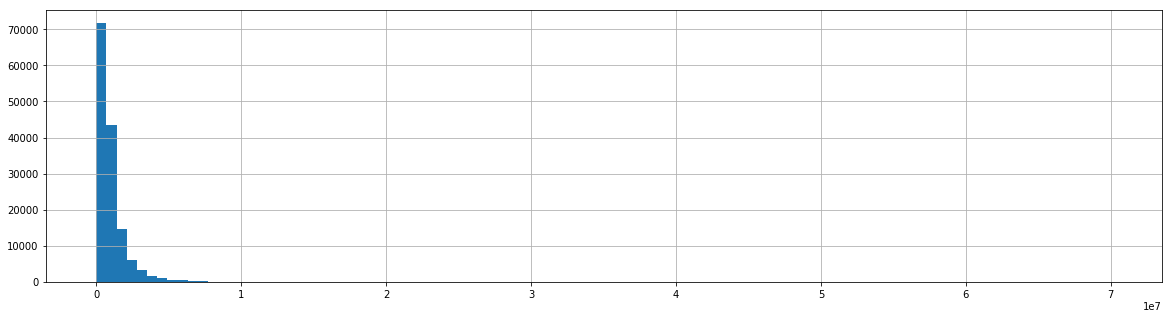

In [22]:
pd.options.display.float_format = '{:,.2f}'.format
plt.rcParams['figure.figsize']=(20,5)
df.price[df.price > 0].hist(bins=100)

В тренировочной выборке есть машины с очень большой ценой и почти нулевым пробегом. Также график показывает, что выборка несбалансирована относительно целевой переменной. Попробуем провести логарифмирование целевой переменной, а также логарифмирование с lambda = 0.15:

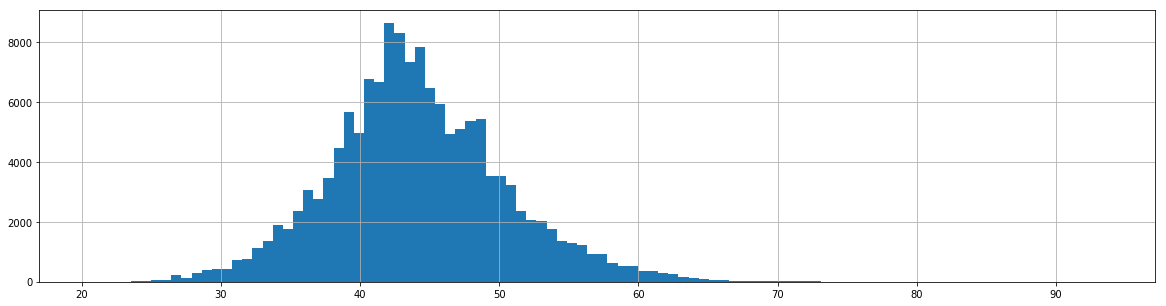

In [23]:
boxcox1p(df.price[df.price > 0],0.15).hist(bins=100)

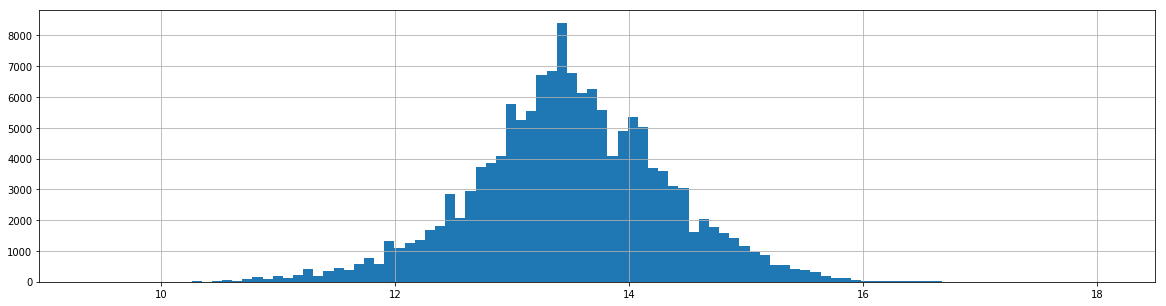

In [24]:
np.log1p(df.price[df.price > 0]).hist(bins=100)

График показывает, что распределение целевой переменной становится похожим на нормальное. В этой связи заменим целевую переменную на логарифм: 

In [25]:
df["price"] = np.log1p(df["price"])

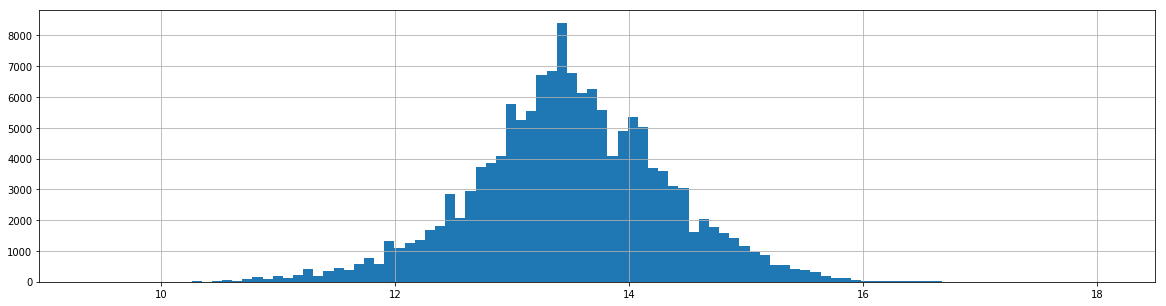

In [26]:
pd.options.display.float_format = '{:,.2f}'.format
plt.rcParams['figure.figsize']=(20,5)
df.price[df.price > 0].hist(bins=100) #ограничиваем цену >0, чтобы посмотреть ее только по тренировочной выборке

Посмотрим внимательнее на price на предмет выбросов:

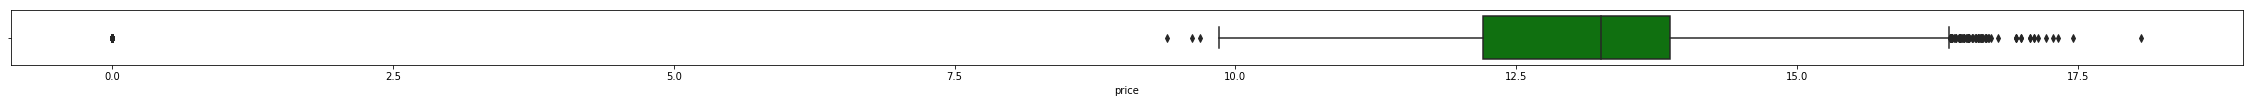

In [27]:
plt.rcParams['figure.figsize']=(40,1)

sns.boxplot(df.price, color='green')

Видим, что есть некоторая доля выбросов в переменной, с которыми необходимо поработать. Поскольку выбросы есть также и в признаках, начнем с того, что определим функцию для определения пороговых значений:

In [28]:
#Определим функцию для дальнейшего анализа выбросов. Функция принимает на вход столбец и расчитывает нижнюю и верхнюю границу 25% и 75% процентилей
def outliers_iqr(ys):
    quartile_1, quartile_3 = np.percentile(ys, [25, 75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    print('Нижняя граница:', lower_bound, 'Верхняя граница:', upper_bound)
    return np.where((ys > upper_bound) | (ys < lower_bound))[0]

Посмотрим на целевую переменную:

In [29]:
o_price = outliers_iqr(df.price)

len(o_price), len(o_price)/df.shape[0]

Нижняя граница: 9.717491295671765 Верхняя граница: 16.352387901819668


(36071, 0.20124638748479676)

Часть значений целевой переменной находятся за пределами 25% и 75% процентилей, эти наблюдения находятся только в тренировочной выборке, так что можно их удалить, ограничив по порогу

UPD: после логарифмирования целевой переменной убрала порог по квартилю

In [30]:
#price_tr = df['price'] < 2325151
#df = df.loc[price_tr]
#sns.boxplot(df.price, color='green')

## 2. Exploratory Data Analysis

### После изучения признаков в датасете (за исключением sample и price) сделаны следующие выовды:
* 1 признак Комплектация разбивается на словарь и делается get dummnies по опциям (174 опции)
* 1 признак url используется для определения марки машины, если допустимо
* 1 признак mileage смотрится на предмет выбросов и переводится в категориальный, кодируется интервалами ['0','0-50k','50k-100k','100k-150k','150-250k','250k-362.5k','>362.5k' ]
* 2 признака modelDate и productionDate перевести в формат дат и вытащить дополнительные признаки: возраст машины(2020 - дата)
* 10 признаков с малой вариативностью кодируются (bodyType, brand, color,fuelType, numberOfDoors, vehicleTransmission, Привод, Руль, Владельцы, ПТС)
* 4 признака (name, vehicleCOnfiguration, engineDisplacement и enginePower) нужно дополнительно изучить и очистить, так как слишком много вариантов
* 1 признак description кодируется на 0 и 1, есть ли описание

In [31]:
pd.set_option('display.max_rows', None)
#test.groupby(['brand', 'bodyType']).size()

### 2.1 Комплектация
Разобьем столбец с комплектациями на значения. Для этого создаем отдельный фрейм Complectations, обрезаем для преобразования в словарь и составляем два множества с названиями категорий и параметрами

In [32]:
import json  

In [33]:
df['Комплектация'].fillna(0,inplace = True)

In [34]:
def find_item(cell): #определим функцию для заполнения полей с элементами комплектации 0 и 1 в зависимости от того, есть ли значение данной комплектации у текущего автомобиля
    try:
        if item in cell:
            return 1
        return 0
    except:
        return 0

params = set() # создаем пустую коллекцию для элементов комплектации

for i in range(0,df.shape[0],1):
    try:
        decoded_train = json.loads(df['Комплектация'][i][2:-2])
        for compl in decoded_train:  # начинаем перебор всех атрибутов в строке с комплектацией
            for i in range(len(compl['values'])): #для каждого атрибута комплектации проходим по каждому элементу и добавляем отсутствующий элемент в коллекцию
                params.add(compl['values'][i])
    except:
        continue

#Создадим 174 новые фичи с учетом комплектаций и заполняем их 0 и 1        
for item in params:
    df[item] = df['Комплектация'].apply(find_item)
    
#Определим функцию, чтобы добавить в отдельное поле длину строки с комплектацией
def compl_filling(row):
    try:
        return len(row)
    except:
        return 0
    
#Применяем написанную ранее функцию к соответствующему признаку    
df['Complectations'] = df['Комплектация'].apply(compl_filling)    

In [35]:
#Визуально проверяем, что все поля действительно создались и датасет выглядит именно так, как планировали:
df.sample(2)

,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,engineDisplacement,enginePower,description,mileage,Комплектация,url,sample,price,Привод_is_NaN,Привод_is_задний,Привод_is_передний,Привод_is_полный,Руль_is_NaN,Руль_is_Левый,Руль_is_Правый,ПТС_is_NaN,ПТС_is_Дубликат,ПТС_is_Оригинал,Владельцы_is_1 владелец,Владельцы_is_2 владельца,Владельцы_is_3 или более,Владельцы_is_Nan,Регулируемый педальный узел,Бортовой компьютер,Активный усилитель руля,Мультимедиа система для задних пассажиров,Количество мест: 7,Парктроник задний,Количество мест: 4,Парктроник передний,Комбинированный (Материал салона),Подушка безопасности водителя,Полноразмерное запасное колесо,Диски 23,Регулировка руля по высоте,Память передних сидений,Защита картера,Система стабилизации (ESP),Ламинированные боковые стекла,Диски 13,Датчик давления в шинах,Ксеноновые/Биксеноновые фары,Лазерные фары,Количество мест: 9,Подушки безопасности боковые,Спортивная подвеска,Память сиденья водителя,Подушки безопасности оконные (шторки),Автоматический корректор фар,Система распознавания дорожных знаков,Прикуриватель и пепельница,Омыватель фар,Электрорегулировка руля,Электрообогрев зоны стеклоочистителей,Система стабилизации рулевого управления (VSM),Адаптивный круиз-контроль,Диски 21,Сиденья с массажем,Запуск двигателя с кнопки,Диски 14,Светлый салон,Электрорегулировка сиденья водителя,Подушка безопасности для защиты коленей водителя,Сигнализация с обратной связью,Система контроля за полосой движения,Центральный замок,Подогрев передних сидений,Аудиосистема,Электрообогрев лобового стекла,Рулевая колонка с памятью положения,Открытие багажника без помощи рук,Система помощи при спуске,Металлик,Подогрев задних сидений,Накладки на пороги,"Система помощи при торможении (BAS, EBD)",Спортивные передние сиденья,Электрообогрев боковых зеркал,Климат-контроль 2-зонный,Android Auto,Светодиодные фары,Искусственная кожа (Материал салона),Система ночного видения,Количество мест: 2,Антипробуксовочная система (ASR),Бронированный кузов,Круиз-контроль,Камера задняя,Стальные диски,Диски 17,Усилитель руля,Вентиляция задних сидений,CarPlay,Аудиосистема Hi-Fi,Мультифункциональное рулевое колесо,Складной столик на спинках передних сидений,Крепление детского кресла (передний ряд) ISOFIX,Датчик усталости водителя,Количество мест: 8,Солнцезащитная шторка на заднем стекле,Третий ряд сидений,Датчик проникновения в салон (датчик объема),Датчик света,Электростеклоподъёмники передние,Ткань (Материал салона),Система контроля слепых зон,Подрулевые лепестки переключения передач,Велюр (Материал салона),Обогрев рулевого колеса,Дистанционный запуск двигателя,Крепление детского кресла (задний ряд) ISOFIX,Функция складывания спинки сиденья пассажира,Диски 20,Диски 15,Диски 16,Кожа (Материал салона),Передний центральный подлокотник,Аэрография,Легкосплавные диски,Система выбора режима движения,Электрорегулировка передних сидений,Система «старт-стоп»,Отделка кожей рычага КПП,Электрообогрев форсунок стеклоомывателей,Диски 19,Кондиционер,Газобаллонное оборудование,Регулировка передних сидений по высоте,Вентиляция передних сидений,Подушка безопасности пассажира,Климат-контроль 1-зонный,Обвес кузова,Третий задний подголовник,Фаркоп,Регулировка руля по вылету,Программируемый предпусковой отопитель,Электростеклоподъёмники задние,USB,Отделка потолка чёрной тканью,Пневмоподвеска,Тонированные стекла,Подушки безопасности боковые задние,Электрорегулировка задних сидений,Система автоматической парковки,Электроскладывание зеркал,Активная подвеска,Система помощи при старте в гору (HSA),Дневные ходовые огни,Рейлинги на крыше,Доводчик дверей,ЭРА-ГЛОНАСС,Система управления дальним светом,Камера передняя,Камера 360°,Яндекс.Авто,Розетка 220V,Система доступа без ключа,Система предотвращения столкновения,Докатка,Аудиосистема с TV,Беспроводная зарядка для смартфона,Розетка 12V,Bluetooth,Датчик дождя,Электропривод зеркал,Иммобилайзер,Охлаждаемый перчаточный ящик,Диски 18,Декоративные м

### 2.2 Поле url
Добавим поле с наличием url, а также выделим из поля марку авто

In [36]:
df['url'].fillna('not available', inplace = True)

In [37]:
def url_update(x):
    if x == 'not available':
        return 'not available'
    
    else:
        return x.split("/")[7]
df['model'] = df.apply(lambda x: url_update(x.url), axis=1)
df = df.drop(['url'], axis = 1)

### 2.3 Анализ mileage
Переходим к следующему признаку. Посмотрим внимательнее на mileage на предмет выбросов:

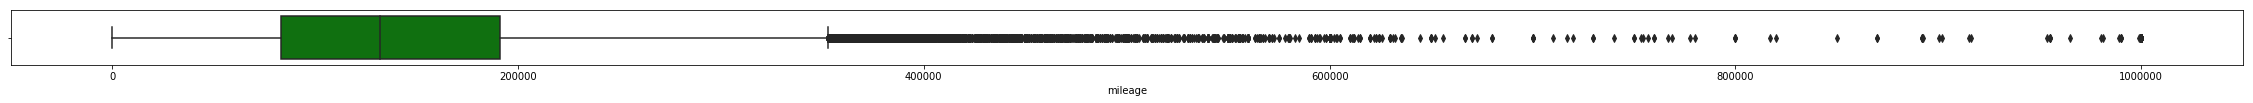

In [38]:
plt.rcParams['figure.figsize']=(40,1)

sns.boxplot(df.mileage, color='green')

На графике видно, что 75% данных находятся в диапазоне 0 - 350 000км, и переменная также содержит определенную долю выбросов. Посмотрим внимательнее, сколько именно значений предположительно являются выбросами

In [39]:
o = outliers_iqr(df.mileage)

len(o), len(o)/df.shape[0]

Нижняя граница: -78866.875 Верхняя граница: 352778.125


(4636, 0.02586505093785916)

Таким образом, порядка 2% данных выходят за пределы диапазона в 75%

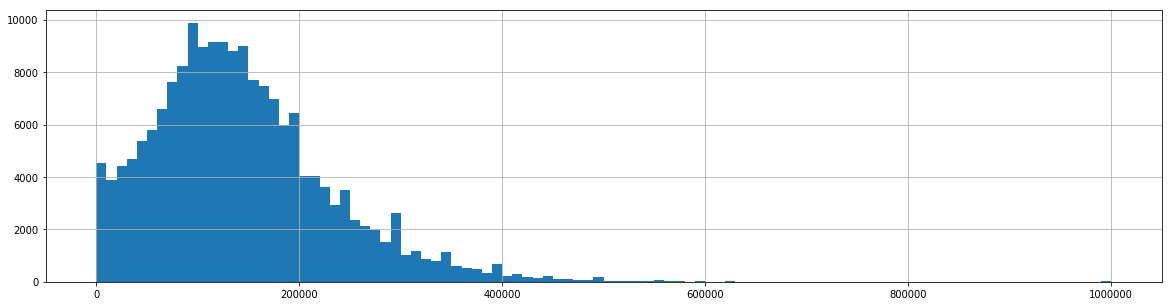

In [40]:
pd.options.display.float_format = '{:,.2f}'.format
plt.rcParams['figure.figsize']=(20,5)
df.mileage.hist(bins=100)

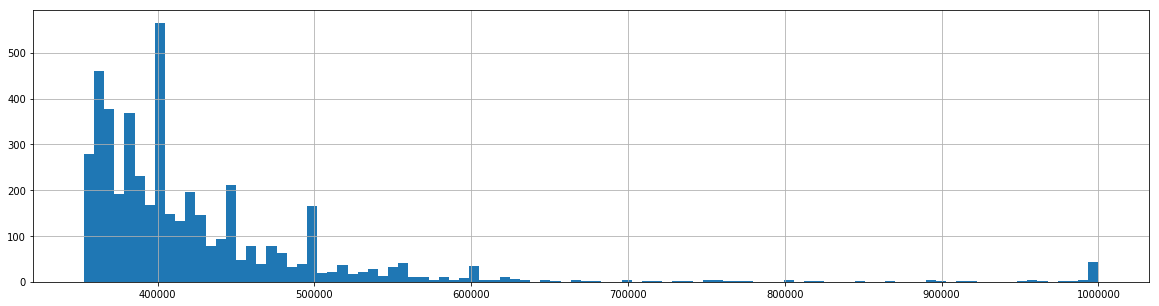

In [41]:
df.mileage[df.mileage >= 352778].hist(bins=100)

In [42]:
#Определим функцию, которая будет заменять все значения пробега выше порогового значения на этот порог и применим ее к признаку в датасете
def func_mileage_tr(x):
    if x > 353000:
        return 353000
    else:
        return x
df['mileage'] = df['mileage'].apply(func_mileage_tr)

In [43]:
#['0','0-50k','50k-100k','100k-150k','150-250k','250k-357k','>357k' ] 
#Также попробуем ввести отдельное поле с разбитым на диапазоны пробегом
# UPD: данное кодирование не помогло и поле было исключено
def func_mileage(x):
    if x > 357050:
        return 6
    elif (x <= 357050) & (x > 250000):
        return 5
    elif (x <= 250000) & (x > 150000):
        return 4
    elif (x <= 150000) & (x > 100000):
        return 3
    elif (x <= 100000) & (x > 50000):
        return 2
    elif (x <= 50000) & (x > 0):
        return 1
    else:
        return 0
df['mileageCode'] = df['mileage'].apply(func_mileage)

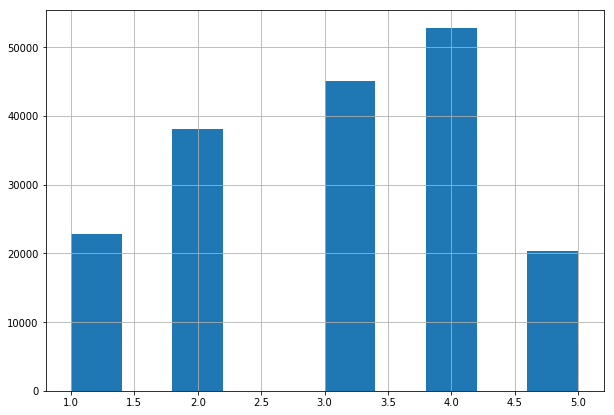

In [44]:
plt.rcParams['figure.figsize']=(10,7)
df.mileageCode.hist()

### 2.4 ProductionDate and ModelDate
Перейдем к изучению дат. В датах также есть выбросы, найдем их пороговые значения

In [45]:
for feature in ['productionDate','modelDate']:
    df[feature]=df[feature].astype('int64')

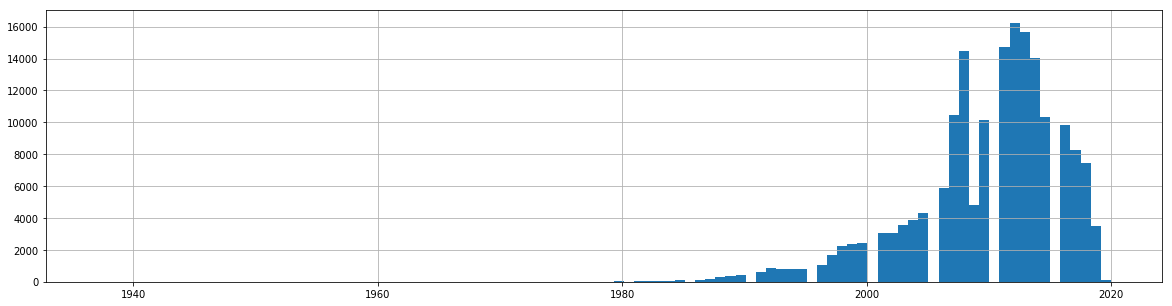

In [46]:
pd.options.display.float_format = '{:,.2f}'.format
plt.rcParams['figure.figsize']=(20,5)
df.productionDate.hist(bins=100)

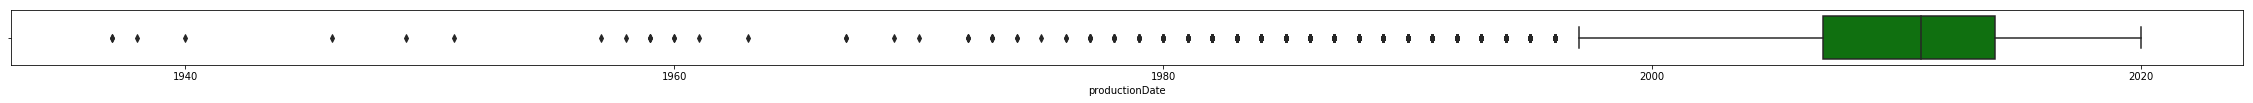

In [47]:
plt.rcParams['figure.figsize']=(40,1)
sns.boxplot(df.productionDate, color='green')

In [48]:
od = outliers_iqr(df.productionDate)

len(od), len(od)/df.shape[0]

Нижняя граница: 1996.5 Верхняя граница: 2024.5


(6709, 0.037430678762316025)

In [49]:
om = outliers_iqr(df.modelDate)

len(om), len(om)/df.shape[0]

Нижняя граница: 1994.5 Верхняя граница: 2022.5


(7275, 0.04058849127975095)

3,6% данных - это старые автомобили до 1996 года

In [50]:
def func_productiondate(x):
    if x < 1997:
        return 1997 #Заменяю все выбросы процентильным значением мощности
    else:
        return x
def func_modeldate(x):
    if x < 1995:
        return 1995 #Заменяю все выбросы процентильным значением мощности
    else:
        return x
df['productionDate'] = df['productionDate'].apply(func_productiondate)
df['modelDate'] = df['modelDate'].apply(func_modeldate)

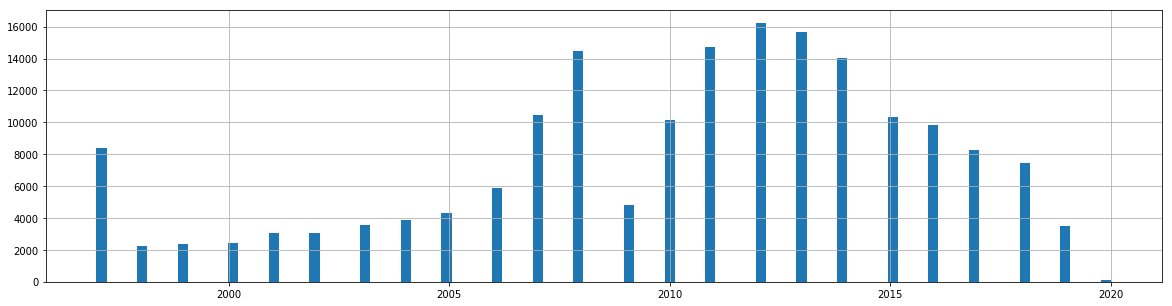

In [51]:
plt.rcParams['figure.figsize']=(20,5)
df.productionDate.hist(bins=100)

Введем дополнительно 2 новых признака: возраст машины и годовой пробег:

In [52]:
df['Years'] = df['productionDate'].apply(lambda x: 2020 - x)

In [53]:
def func_mileage_per_year(x,y):
    if x == 0:
        return 0
    elif y == 0:
        return x
    else:
        return round(x/y,0)
df['mileage_per_year'] = df.apply(lambda x: func_mileage_per_year(x.mileage, x.Years), axis=1)

Посмотрим на график распределения годового пробега:

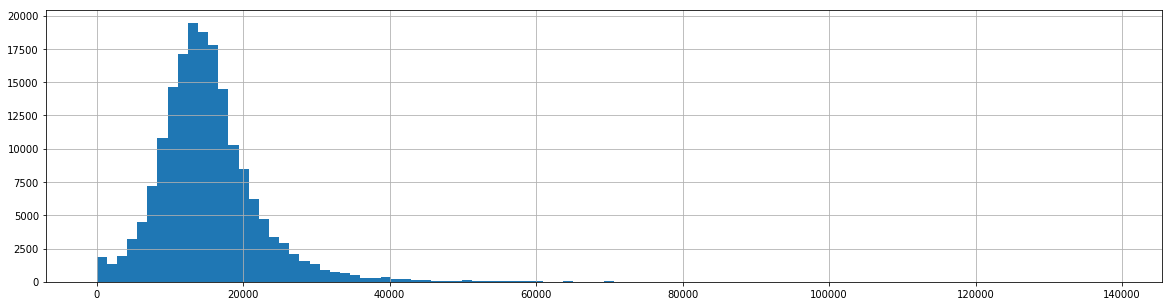

In [54]:
df.mileage_per_year.hist(bins=100)

Визуальный анализ показал, что необходимо провести логарифмирование признака для того, чтобы распределение стало больше похоже на нормальное. Сделаем это:

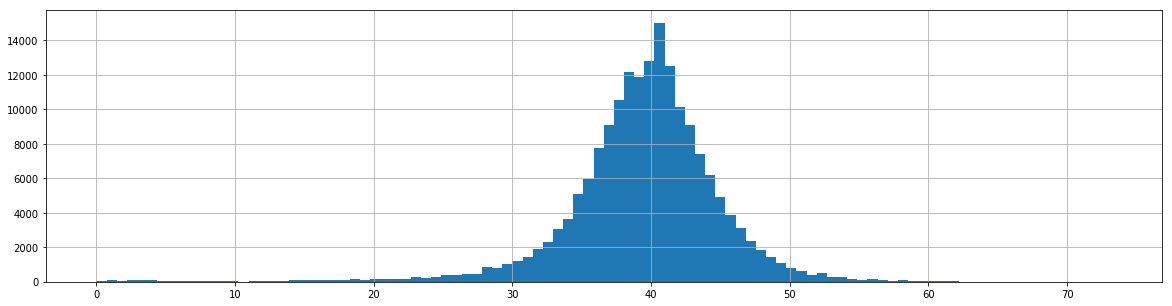

In [55]:
boxcox1p(df.mileage_per_year, 0.25).hist(bins=100)

In [56]:
df['mileage_per_year'] =boxcox1p(df['mileage_per_year'], 0.25)

### 2.5 Анализ vehicleConfiguration, engineDisplacement и enginePower

Перейдем к изучению признаков с большой вариативностью. Так, для поля vehicleConfiguration отсечем все значения признака, которые встречаются реже 30 самых популярных:

In [57]:
all_vC = df.vehicleConfiguration.value_counts().index
top_vC = list(all_vC)[:30]
vC_to_throw_away = list(set(all_vC) - set(top_vC))
df.loc[df['vehicleConfiguration'].isin(vC_to_throw_away), 'vehicleConfiguration'] = 'vC_other'

Перехожу к следующему признаку. Для него применим сплит и выделим только численную часть. В ходе работы было изучено две возможности: использовать признак как число и как категориальный признак. Второй вариант при построении модели отработал лучше

In [58]:
df.engineDisplacement = df.engineDisplacement.map(lambda n: n.split(" ")[0])

In [59]:
#заменяю значение undefined на топовое
#df['engineDisplacement'].replace('undefined','2.0', inplace = True)

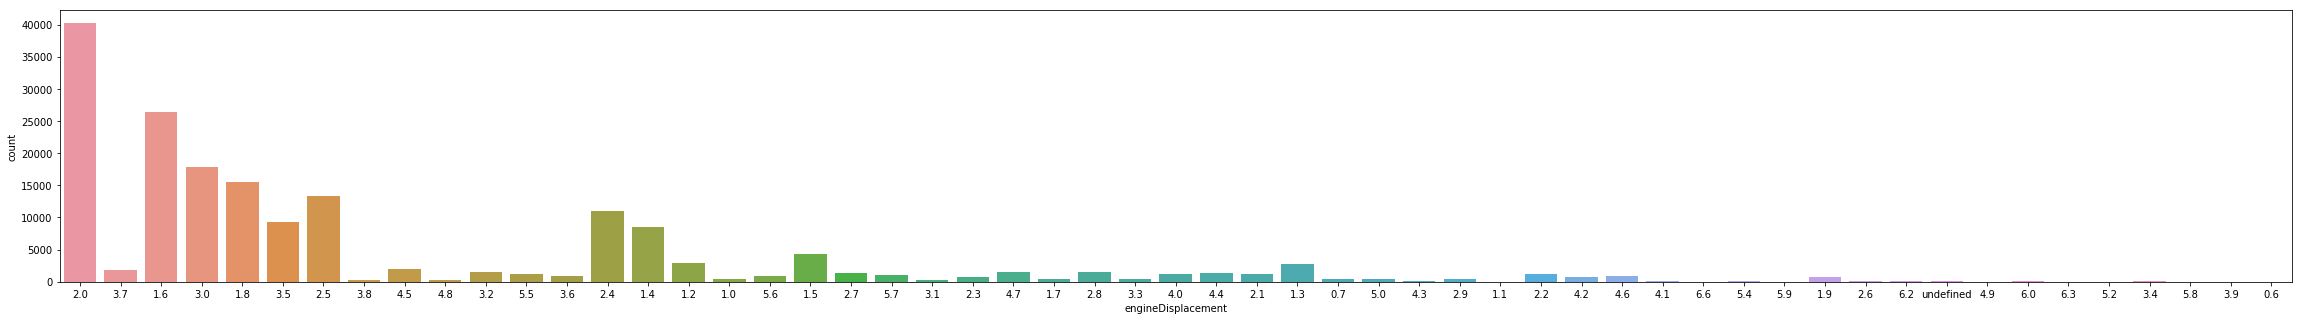

In [60]:
plt.rcParams['figure.figsize']=(40,5)
sns.countplot(x='engineDisplacement', data=df)

In [61]:
df['engineDisplacement'].unique()

array(['2.0', '3.7', '1.6', '3.0', '1.8', '3.5', '2.5', '3.8', '4.5',
       '4.8', '3.2', '5.5', '3.6', '2.4', '1.4', '1.2', '1.0', '5.6',
       '1.5', '2.7', '5.7', '3.1', '2.3', '4.7', '1.7', '2.8', '3.3',
       '4.0', '4.4', '2.1', '1.3', '0.7', '5.0', '4.3', '2.9', '1.1',
       '2.2', '4.2', '4.6', '4.1', '6.6', '5.4', '5.9', '1.9', '2.6',
       '6.2', 'undefined', '4.9', '6.0', '6.3', '5.2', '3.4', '5.8',
       '3.9', '0.6'], dtype=object)

In [62]:
#df['engineDisplacement']=df['engineDisplacement'].astype('float64')
#df['engineDisplacement']=df['engineDisplacement'].astype('int64')

In [63]:
#plt.rcParams['figure.figsize']=(20,5)
#df.engineDisplacement.hist(bins=100)

In [64]:
#df['engineDisplacement'].value_counts()[:11] #данный диапазон значительно обьемов двигателя отличается от остальной выборки, попробуем оставшиеся варианты закодировать переменной other 

In [65]:
#all_eD = df.engineDisplacement.value_counts().index
#top_eD = list(all_eD)[:25]
#eD_to_throw_away = list(set(all_eD) - set(top_eD))
#df.loc[df['engineDisplacement'].isin(eD_to_throw_away), 'engineDisplacement'] = 'eD_other'

In [66]:
#df = df.join(pd.get_dummies(df.engineDisplacement, drop_first=False))
#df = df.drop('engineDisplacement', axis = 1)

Признака enginePower сделаем числовым и посмотрим на его распределение:

In [67]:
df.enginePower = df.enginePower.map(lambda n: n.split(" ")[0])
df.enginePower=df.enginePower.astype('int64')

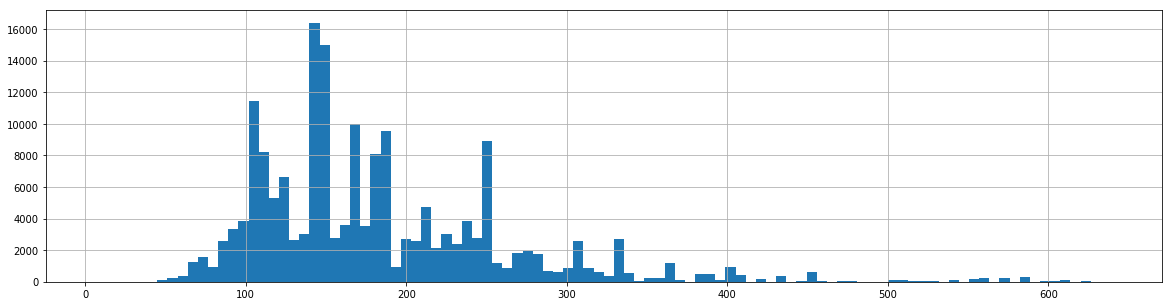

In [68]:
pd.options.display.float_format = '{:,.2f}'.format
plt.rcParams['figure.figsize']=(20,5)
df.enginePower.hist(bins=100)

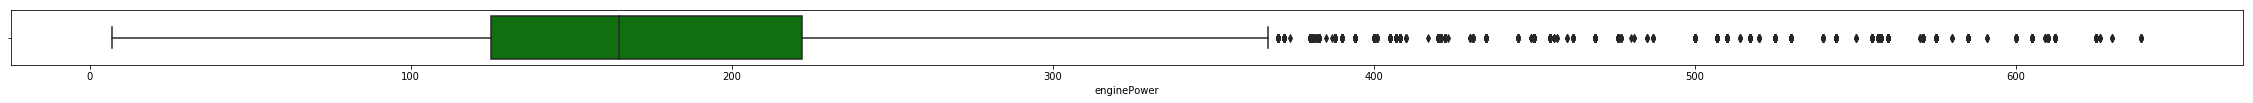

In [69]:
plt.rcParams['figure.figsize']=(40,1)
sns.boxplot(df.enginePower, color='green')

Как видно на визуализации у мощности двигателя есть очень длинный хвост, попробуем применить процентильную оценку:

In [70]:
oeP = outliers_iqr(df.enginePower)

len(oeP), len(oeP)/df.shape[0]

Нижняя граница: -20.5 Верхняя граница: 367.5


(5593, 0.031204320512391345)

3,6% в данных имеют очень большую мощность двигателя, для таких значений можно ввести пороговое значение:

In [71]:
def func_enginePower(x):
    if x > 367.0:
        return 367.0 #Заменяю все выбросы процентильным значением мощности
    else:
        return x
df['enginePower'] = df['enginePower'].apply(func_enginePower)

### 2.6 Анализ полей с описанием и отзывами
Для поля с описанием авто была придумана следующая обработка. Первым шагом рисуем облако наиболее встречающихся фраз с учетом некоторого количества стоп-слов, которые были выброшены из рассмотрения:

In [72]:
from wordcloud import WordCloud, STOPWORDS

In [73]:
stop = ['nan','при покупке', 'вашего автомобиля','вы можете','при обмене','trade in','вы  можете','данный автомобиль']

In [74]:
text = ' '.join(df['description'].str.lower().values[-1000000:])
wordcloud = WordCloud(max_font_size=None, stopwords=stop, background_color='white',
                      width=1200, height=1000).generate(text)

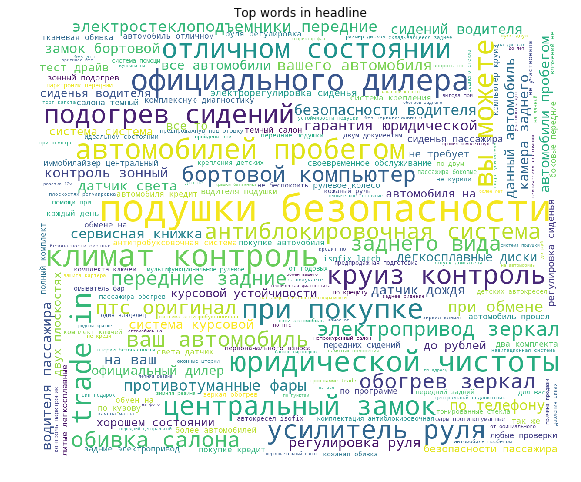

In [75]:
plt.figure(figsize=(18, 8))
plt.imshow(wordcloud)
plt.title('Top words in headline')
plt.axis("off")
plt.show()

Вторым шагом на основе визуального анализа был сформирован словарь основных фраз, встречающихся в обьявлениях. Далее было принято решение модифицировать признак description, закодировав его 1,если в данном признаке встречали фразы из словаря, и 0, если таких слов в нем не было.

In [76]:
def is_part_in_list(str_):
    i = 0
    desc_list = {'подушки безопасности','дтп','климат контроль','электростеклоподъемники передние','антиблокировочная система','бортовой компьютер','подогрев сидений',
             'отличном состоянии','круиз контроль','обивка салона','усилитель руля', 'обогрев зеркал','центральный замок','регулировка руля','птс оригинал','противотуманные фары'}
    for word in desc_list :
        if word.lower() in str_.lower():
            return 1
    return 0

df['description'] = df['description'].apply(is_part_in_list)

# UPD: Данное решение повлияло на качество модели и улучшило качество прогноза

In [77]:
#Визуально проконтролируем, что в выборке не появились никакие ошибки:
df.sample(2)

,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,engineDisplacement,enginePower,description,mileage,Комплектация,sample,price,Привод_is_NaN,Привод_is_задний,Привод_is_передний,Привод_is_полный,Руль_is_NaN,Руль_is_Левый,Руль_is_Правый,ПТС_is_NaN,ПТС_is_Дубликат,ПТС_is_Оригинал,Владельцы_is_1 владелец,Владельцы_is_2 владельца,Владельцы_is_3 или более,Владельцы_is_Nan,Регулируемый педальный узел,Бортовой компьютер,Активный усилитель руля,Мультимедиа система для задних пассажиров,Количество мест: 7,Парктроник задний,Количество мест: 4,Парктроник передний,Комбинированный (Материал салона),Подушка безопасности водителя,Полноразмерное запасное колесо,Диски 23,Регулировка руля по высоте,Память передних сидений,Защита картера,Система стабилизации (ESP),Ламинированные боковые стекла,Диски 13,Датчик давления в шинах,Ксеноновые/Биксеноновые фары,Лазерные фары,Количество мест: 9,Подушки безопасности боковые,Спортивная подвеска,Память сиденья водителя,Подушки безопасности оконные (шторки),Автоматический корректор фар,Система распознавания дорожных знаков,Прикуриватель и пепельница,Омыватель фар,Электрорегулировка руля,Электрообогрев зоны стеклоочистителей,Система стабилизации рулевого управления (VSM),Адаптивный круиз-контроль,Диски 21,Сиденья с массажем,Запуск двигателя с кнопки,Диски 14,Светлый салон,Электрорегулировка сиденья водителя,Подушка безопасности для защиты коленей водителя,Сигнализация с обратной связью,Система контроля за полосой движения,Центральный замок,Подогрев передних сидений,Аудиосистема,Электрообогрев лобового стекла,Рулевая колонка с памятью положения,Открытие багажника без помощи рук,Система помощи при спуске,Металлик,Подогрев задних сидений,Накладки на пороги,"Система помощи при торможении (BAS, EBD)",Спортивные передние сиденья,Электрообогрев боковых зеркал,Климат-контроль 2-зонный,Android Auto,Светодиодные фары,Искусственная кожа (Материал салона),Система ночного видения,Количество мест: 2,Антипробуксовочная система (ASR),Бронированный кузов,Круиз-контроль,Камера задняя,Стальные диски,Диски 17,Усилитель руля,Вентиляция задних сидений,CarPlay,Аудиосистема Hi-Fi,Мультифункциональное рулевое колесо,Складной столик на спинках передних сидений,Крепление детского кресла (передний ряд) ISOFIX,Датчик усталости водителя,Количество мест: 8,Солнцезащитная шторка на заднем стекле,Третий ряд сидений,Датчик проникновения в салон (датчик объема),Датчик света,Электростеклоподъёмники передние,Ткань (Материал салона),Система контроля слепых зон,Подрулевые лепестки переключения передач,Велюр (Материал салона),Обогрев рулевого колеса,Дистанционный запуск двигателя,Крепление детского кресла (задний ряд) ISOFIX,Функция складывания спинки сиденья пассажира,Диски 20,Диски 15,Диски 16,Кожа (Материал салона),Передний центральный подлокотник,Аэрография,Легкосплавные диски,Система выбора режима движения,Электрорегулировка передних сидений,Система «старт-стоп»,Отделка кожей рычага КПП,Электрообогрев форсунок стеклоомывателей,Диски 19,Кондиционер,Газобаллонное оборудование,Регулировка передних сидений по высоте,Вентиляция передних сидений,Подушка безопасности пассажира,Климат-контроль 1-зонный,Обвес кузова,Третий задний подголовник,Фаркоп,Регулировка руля по вылету,Программируемый предпусковой отопитель,Электростеклоподъёмники задние,USB,Отделка потолка чёрной тканью,Пневмоподвеска,Тонированные стекла,Подушки безопасности боковые задние,Электрорегулировка задних сидений,Система автоматической парковки,Электроскладывание зеркал,Активная подвеска,Система помощи при старте в гору (HSA),Дневные ходовые огни,Рейлинги на крыше,Доводчик дверей,ЭРА-ГЛОНАСС,Система управления дальним светом,Камера передняя,Камера 360°,Яндекс.Авто,Розетка 220V,Система доступа без ключа,Система предотвращения столкновения,Докатка,Аудиосистема с TV,Беспроводная зарядка для смартфона,Розетка 12V,Bluetooth,Датчик дождя,Электропривод зеркал,Иммобилайзер,Охлаждаемый перчаточный ящик,Диски 18,Декоративные молди

## 3. Feature engineering and transformation

In [78]:
#Удаляю признаки, которые не сработали при экспериментах

df.drop(['name','mileageCode','Комплектация','model'], axis=1, inplace = True)

In [79]:
#Введем новый признак - разница между годами производства и модели
df['Year_Gen'] = df['productionDate'].sub(df['modelDate'], axis=0)

In [80]:
#Переведем часть признаков в int
for feature in ['numberOfDoors','Years','Year_Gen', 'enginePower']:
    df[feature]=df[feature].astype('int64')

In [81]:
# Нормализовываем нуждающиеся в этом признаки
a_features = df[['modelDate','numberOfDoors','productionDate', 'enginePower','mileage','Complectations','Years','mileage_per_year','Year_Gen']].values
norm_features = (a_features - a_features.mean(axis=0)) / a_features.std(axis=0)
df.loc[:, ['modelDate','numberOfDoors','productionDate', 'enginePower','mileage','Complectations','Years','mileage_per_year','Year_Gen']] = norm_features

In [82]:
#Закодируем категориальные фичи
from sklearn.preprocessing import LabelEncoder

labelencoder = LabelEncoder()
for feature in ['brand','bodyType', 'color', 'fuelType', 'vehicleConfiguration', 'vehicleTransmission','engineDisplacement']:
    #df[feature] = df[feature].apply(df[feature].value_counts().get)
    df[feature] = labelencoder.fit_transform(df[feature])    

In [83]:
df.sample(2)

,bodyType,brand,color,fuelType,modelDate,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,engineDisplacement,enginePower,description,mileage,sample,price,Привод_is_NaN,Привод_is_задний,Привод_is_передний,Привод_is_полный,Руль_is_NaN,Руль_is_Левый,Руль_is_Правый,ПТС_is_NaN,ПТС_is_Дубликат,ПТС_is_Оригинал,Владельцы_is_1 владелец,Владельцы_is_2 владельца,Владельцы_is_3 или более,Владельцы_is_Nan,Регулируемый педальный узел,Бортовой компьютер,Активный усилитель руля,Мультимедиа система для задних пассажиров,Количество мест: 7,Парктроник задний,Количество мест: 4,Парктроник передний,Комбинированный (Материал салона),Подушка безопасности водителя,Полноразмерное запасное колесо,Диски 23,Регулировка руля по высоте,Память передних сидений,Защита картера,Система стабилизации (ESP),Ламинированные боковые стекла,Диски 13,Датчик давления в шинах,Ксеноновые/Биксеноновые фары,Лазерные фары,Количество мест: 9,Подушки безопасности боковые,Спортивная подвеска,Память сиденья водителя,Подушки безопасности оконные (шторки),Автоматический корректор фар,Система распознавания дорожных знаков,Прикуриватель и пепельница,Омыватель фар,Электрорегулировка руля,Электрообогрев зоны стеклоочистителей,Система стабилизации рулевого управления (VSM),Адаптивный круиз-контроль,Диски 21,Сиденья с массажем,Запуск двигателя с кнопки,Диски 14,Светлый салон,Электрорегулировка сиденья водителя,Подушка безопасности для защиты коленей водителя,Сигнализация с обратной связью,Система контроля за полосой движения,Центральный замок,Подогрев передних сидений,Аудиосистема,Электрообогрев лобового стекла,Рулевая колонка с памятью положения,Открытие багажника без помощи рук,Система помощи при спуске,Металлик,Подогрев задних сидений,Накладки на пороги,"Система помощи при торможении (BAS, EBD)",Спортивные передние сиденья,Электрообогрев боковых зеркал,Климат-контроль 2-зонный,Android Auto,Светодиодные фары,Искусственная кожа (Материал салона),Система ночного видения,Количество мест: 2,Антипробуксовочная система (ASR),Бронированный кузов,Круиз-контроль,Камера задняя,Стальные диски,Диски 17,Усилитель руля,Вентиляция задних сидений,CarPlay,Аудиосистема Hi-Fi,Мультифункциональное рулевое колесо,Складной столик на спинках передних сидений,Крепление детского кресла (передний ряд) ISOFIX,Датчик усталости водителя,Количество мест: 8,Солнцезащитная шторка на заднем стекле,Третий ряд сидений,Датчик проникновения в салон (датчик объема),Датчик света,Электростеклоподъёмники передние,Ткань (Материал салона),Система контроля слепых зон,Подрулевые лепестки переключения передач,Велюр (Материал салона),Обогрев рулевого колеса,Дистанционный запуск двигателя,Крепление детского кресла (задний ряд) ISOFIX,Функция складывания спинки сиденья пассажира,Диски 20,Диски 15,Диски 16,Кожа (Материал салона),Передний центральный подлокотник,Аэрография,Легкосплавные диски,Система выбора режима движения,Электрорегулировка передних сидений,Система «старт-стоп»,Отделка кожей рычага КПП,Электрообогрев форсунок стеклоомывателей,Диски 19,Кондиционер,Газобаллонное оборудование,Регулировка передних сидений по высоте,Вентиляция передних сидений,Подушка безопасности пассажира,Климат-контроль 1-зонный,Обвес кузова,Третий задний подголовник,Фаркоп,Регулировка руля по вылету,Программируемый предпусковой отопитель,Электростеклоподъёмники задние,USB,Отделка потолка чёрной тканью,Пневмоподвеска,Тонированные стекла,Подушки безопасности боковые задние,Электрорегулировка задних сидений,Система автоматической парковки,Электроскладывание зеркал,Активная подвеска,Система помощи при старте в гору (HSA),Дневные ходовые огни,Рейлинги на крыше,Доводчик дверей,ЭРА-ГЛОНАСС,Система управления дальним светом,Камера передняя,Камера 360°,Яндекс.Авто,Розетка 220V,Система доступа без ключа,Система предотвращения столкновения,Докатка,Аудиосистема с TV,Беспроводная зарядка для смартфона,Розетка 12V,Bluetooth,Датчик дождя,Электропривод зеркал,Иммобилайзер,Охлаждаемый перчаточный ящик,Диски 18,Декоративные молдинги,Навигационная 

Посмотрим на получившийся датасет:

In [84]:
#Посмотрим на названия столбцов
working = df.columns.tolist()
print(working)

['bodyType', 'brand', 'color', 'fuelType', 'modelDate', 'numberOfDoors', 'productionDate', 'vehicleConfiguration', 'vehicleTransmission', 'engineDisplacement', 'enginePower', 'description', 'mileage', 'sample', 'price', 'Привод_is_NaN', 'Привод_is_задний', 'Привод_is_передний', 'Привод_is_полный', 'Руль_is_NaN', 'Руль_is_Левый', 'Руль_is_Правый', 'ПТС_is_NaN', 'ПТС_is_Дубликат', 'ПТС_is_Оригинал', 'Владельцы_is_1\xa0владелец', 'Владельцы_is_2\xa0владельца', 'Владельцы_is_3 или более', 'Владельцы_is_Nan', 'Регулируемый педальный узел', 'Бортовой компьютер', 'Активный усилитель руля', 'Мультимедиа система для задних пассажиров', 'Количество мест: 7', 'Парктроник задний', 'Количество мест: 4', 'Парктроник передний', 'Комбинированный (Материал салона)', 'Подушка безопасности водителя', 'Полноразмерное запасное колесо', 'Диски 23', 'Регулировка руля по высоте', 'Память передних сидений', 'Защита картера', 'Система стабилизации (ESP)', 'Ламинированные боковые стекла', 'Диски 13', 'Датчик дав

In [85]:
#Визуализируем попарные распределения в тесте:
#sns.pairplot(df.loc[df['sample'] == 0])

In [86]:
#Визуализируем попарные распределения в трейне:
#sns.pairplot(df.loc[df['sample'] == 1])

In [87]:
#Посмотрим на корреляционную матрицу признаков

#corr = df.corr()
#sns.set_context("notebook", font_scale=1.0, rc={"lines.linewidth": 2.5})
#plt.figure(figsize=(13,7))
#a = sns.heatmap(corr, annot=True, fmt='.2f')
#rotx = a.set_xticklabels(a.get_xticklabels(), rotation=90)
#roty = a.set_yticklabels(a.get_yticklabels(), rotation=30)

## 4. Data Preparation for training

In [88]:
#Сохраняем тестовую выборку для дальнейшего обучения
train_preproc = df.loc[df['sample'] == 1]
train_preproc = train_preproc.drop('sample', axis=1)


#Сохраняем обратно валидационную выборку:
X_sub = df.loc[df['sample'] == 0]
X_sub = X_sub.drop('sample', axis=1)

print(train_preproc.shape)
print(X_sub.shape)

#Выделяем целевую переменную
X = train_preproc.drop('price', axis=1)
y = train_preproc.price.values
#y_log = np.log(train_preproc.price.values)

X_sub = X_sub.drop('price', axis=1)

(143248, 206)
(35990, 206)


Определи функцию для расчета требуемой метрики оценки качества:

In [89]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

## 5. Построение модели.

## CatBoost

In [90]:
# Keep list of all categoricalb features in dataset to specify this for CatBoost
#X_train.nunique()
#cat_features_ids = np.where(X_train.apply(pd.Series.nunique) < 52)[0].tolist()
#cat_features_ids = [0,1,2, 3, 7, 8]

In [91]:
#Посчитаем, какого размера необходима тестовая выборка
VAL_SIZE   = X_sub.shape[0]/X.shape[0]

In [92]:
# Настройки алгоритма
N_FOLDS    = 7
ITERATIONS = 6000
LR         = 0.1

#Разбиваем выборку на трейн и тест:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

По итогам экспериментов с параметрами алгоритма Catboost были сделаны следующие выводы:
* изменение типа бутсрапа на bayesian дало улучшение скора 
* увеличение глубины деревьев улучшает ошибку, но увеличивает время обучения, было взято значение 12
* уменьшение bagging_temerature дает улучшение алгоритма

In [93]:
plt.rcParams['figure.figsize']=(8,10)

In [94]:
model = CatBoostRegressor(iterations = ITERATIONS,
                              learning_rate = LR,
                              l2_leaf_reg = 0.5,
                              depth=12,
                              od_type='Iter',
                              od_wait=50,
                              bootstrap_type = 'Bayesian',
                              bagging_temperature = 0.1,
                              eval_metric='MAPE',
                              random_seed = RANDOM_SEED,)
model.fit(X_train, y_train,
        # cat_features=cat_features_ids,
         eval_set=(X_test, y_test),
         verbose_eval=500,
         use_best_model=True,
         plot=True)

feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).sort_values(ascending=False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.0439492	test: 0.0435118	best: 0.0435118 (0)	total: 444ms	remaining: 44m 23s
500:	learn: 0.0059823	test: 0.0086132	best: 0.0086131 (499)	total: 2m 50s	remaining: 31m 14s
1000:	learn: 0.0042894	test: 0.0084623	best: 0.0084623 (1000)	total: 5m 47s	remaining: 28m 56s
1500:	learn: 0.0033221	test: 0.0084217	best: 0.0084206 (1473)	total: 8m 49s	remaining: 26m 27s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.008413800184
bestIteration = 1595

Shrink model to first 1596 iterations.


enginePower            12.74
productionDate         12.23
brand                  10.20
modelDate               9.33
Years                   9.08
engineDisplacement      8.88
bodyType                6.43
mileage                 5.54
fuelType                3.66
vehicleConfiguration    2.48
color                   2.29
mileage_per_year        2.26
vehicleTransmission     1.92
numberOfDoors           1.42
Complectations          1.25
dtype: float64

Проведем обучение на 7 фолдах, предварительно определив функцию для обучения модели:

In [95]:
def cat_model(y_train, X_train, X_test, y_test):
    model = CatBoostRegressor(iterations = ITERATIONS,
                              learning_rate = LR,
                              l2_leaf_reg = 0.5,
                              depth=12,
                              od_type='Iter',
                              od_wait=50,
                              bootstrap_type = 'Bayesian',
                              bagging_temperature = 0.1,
                              eval_metric='MAPE',
                              random_seed = RANDOM_SEED,)
    model.fit(X_train, y_train,
              #cat_features=cat_features_ids,
              eval_set=(X_test, y_test),
              #verbose=False,
              verbose=500,
              use_best_model=True,
              plot=False)
    

    return(model)

In [96]:
submissions = pd.DataFrame(0,columns=["sub_1"], index=sample_submission.index) # куда пишем предикты по каждой модели
score_ls = []
splits = list(KFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_SEED).split(X, y))

for idx, (train_idx, test_idx) in tqdm(enumerate(splits), total=N_FOLDS,):
    # use the indexes to extract the folds in the train and validation data
    X_train, y_train, X_test, y_test = X.iloc[train_idx], y[train_idx], X.iloc[test_idx], y[test_idx]
    # model for this fold
    model = cat_model(y_train, X_train, X_test, y_test,)
    
    # score model on test
    test_predict = model.predict(X_test)
    test_score = mape(y_test, test_predict)
    score_ls.append(test_score)
    print(f"{idx+1} Fold Test MAPE: {mape(y_test, test_predict):0.6f}")
    
    #feat_importances = pd.Series(model.feature_importances_, index=X.columns)
    #print(feat_importances.nlargest(15).sort_values())
    # submissions
    submissions[f'sub_{idx+1}'] = np.expm1(model.predict(X_sub))
    model.save_model(f'catboost_fold_{idx+1}.model')

print(f'Mean Score: {np.mean(score_ls):0.6f}')
print(f'Std Score: {np.std(score_ls):0.6f}')
print(f'Max Score: {np.max(score_ls):0.6f}')
print(f'Min Score: {np.min(score_ls):0.6f}')    

0:	learn: 0.0439078	test: 0.0433920	best: 0.0433920 (0)	total: 341ms	remaining: 34m 3s
500:	learn: 0.0061017	test: 0.0084845	best: 0.0084845 (500)	total: 2m 51s	remaining: 31m 26s
1000:	learn: 0.0044941	test: 0.0083039	best: 0.0083036 (998)	total: 5m 43s	remaining: 28m 36s
1500:	learn: 0.0035513	test: 0.0082541	best: 0.0082541 (1500)	total: 8m 36s	remaining: 25m 47s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.008240785659
bestIteration = 1645

Shrink model to first 1646 iterations.
1 Fold Test MAPE: 0.008241
0:	learn: 0.0438505	test: 0.0437909	best: 0.0437909 (0)	total: 350ms	remaining: 34m 58s
500:	learn: 0.0060544	test: 0.0085518	best: 0.0085518 (500)	total: 2m 53s	remaining: 31m 42s
1000:	learn: 0.0044740	test: 0.0083851	best: 0.0083836 (993)	total: 5m 46s	remaining: 28m 52s
1500:	learn: 0.0035199	test: 0.0083299	best: 0.0083289 (1488)	total: 8m 40s	remaining: 26m
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.008328854746
bestIteration =

Гипотеза: возьмем предсказания моделей с выбранными параметрами с лучшим скором, обучим модель с выбранным числом фичей и обьединим предсказания. Итоговый скор должен уменьшиться.
По итогам обучения модели выбираю 5 фолдов с лучшим скором, объединяю их и считаю среднее:

In [97]:
submissions_low6 = submissions[['sub_1','sub_2','sub_3','sub_4','sub_6']]
submissions_low6.head(10)

,sub_1,sub_2,sub_3,sub_4,sub_6
0,"2,196,762.83","2,226,396.18","2,171,275.19","2,227,951.33","2,236,118.40"
1,"1,543,404.00","1,495,037.29","1,547,008.13","1,447,136.93","1,429,782.45"
2,"485,024.77","498,454.82","472,332.79","493,232.02","488,480.70"
3,"2,969,348.97","2,967,204.39","2,987,325.86","2,931,425.48","2,916,045.14"
4,"1,134,299.18","1,125,367.62","1,112,420.97","1,144,741.45","1,172,978.23"
5,"820,786.94","785,859.40","790,362.92","854,700.64","807,081.00"
6,"377,678.74","387,245.53","390,616.67","378,838.63","380,840.61"
7,"556,380.36","533,467.31","525,908.73","569,274.64","563,805.91"
8,"1,788,693.37","1,799,520.78","2,015,039.46","1,826,277.67","1,805,305.83"
9,"585,077.77","570,634.79","579,120.47","581,343.38","597,819.47"


In [98]:
# Данный подход дал результат 9.26766 на Лидерборде и был использован как финальное решение
submissions_low6['blend'] = (submissions_low6.sum(axis=1))/len(submissions_low6.columns)
sample_submission['price'] = submissions_low6['blend'].values
sample_submission.to_csv(f'submission_blend_6_v{VERSION}.csv', index=False)
sample_submission.head(10)

,id,price
0,0,"2,211,700.79"
1,1,"1,492,473.76"
2,2,"487,505.02"
3,3,"2,954,269.97"
4,4,"1,137,961.49"
5,5,"811,758.18"
6,6,"383,044.04"
7,7,"549,767.39"
8,8,"1,846,967.42"
9,9,"582,799.18"


# LightGBM
Помимо работы с Catboost было интересно попробовать работу с другими алгоритмами, например, с LigthGBM.
Алгоритм не работает с не-ASCII названиями признаков, поэтому перед обучением закодируем названия столбцов в датасете:

In [99]:
mas=[] # объявление пустого списка 
for i in range(X_train.shape[1]): 
    mas.append('col_'+ str(i)) 
    
X_train.columns = mas
X_test.columns = mas

Определим функцию для обучения модели:

In [100]:
def LGBReg(x_train, y_train, x_val, y_val):
    lgb_reg = lgb.LGBMRegressor(
        n_jobs=-1,
        tree_method='auto',
        learning_rate=0.02,
        max_depth=10,
        num_leaves = 600,
        n_estimators=10000,
        colsample_bytree=0.8, 
        subsample=0.8, 
        seed=42)
    
    lgb_reg.fit(
        x_train, 
        y_train, 
        eval_metric="mape", 
        eval_set=[(x_train, y_train), (x_val, y_val)], 
        verbose=500, 
        early_stopping_rounds = 70)
    return lgb_reg


In [101]:
# Посмотрим на работу функции на всей выборке
lgb_reg_1 = LGBReg(X_train, y_train, X_test, y_test)

Training until validation scores don't improve for 70 rounds
[500]	training's mape: 0.00741351	training's l2: 0.0209781	valid_1's mape: 0.00872398	valid_1's l2: 0.0298574
[1000]	training's mape: 0.00680473	training's l2: 0.0177723	valid_1's mape: 0.00854293	valid_1's l2: 0.028941
[1500]	training's mape: 0.00634849	training's l2: 0.0155434	valid_1's mape: 0.00844841	valid_1's l2: 0.0285262
[2000]	training's mape: 0.00595636	training's l2: 0.0138148	valid_1's mape: 0.0083854	valid_1's l2: 0.0283173
Early stopping, best iteration is:
[2100]	training's mape: 0.00588272	training's l2: 0.0135054	valid_1's mape: 0.0083757	valid_1's l2: 0.0282948


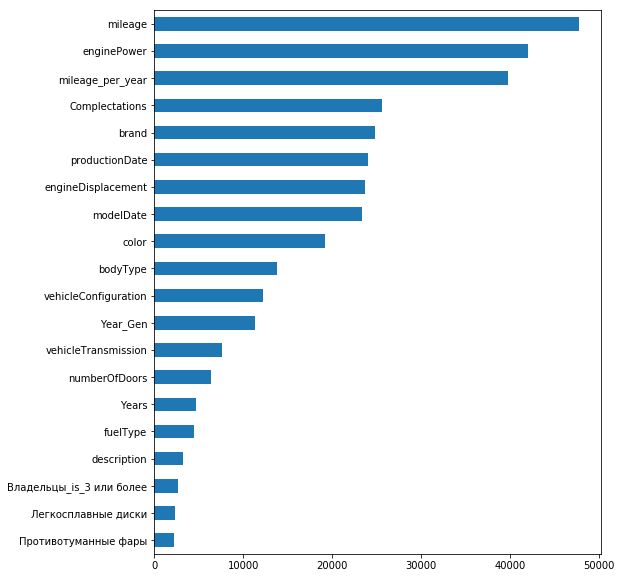

In [102]:
feat_importances_lgb = pd.Series(lgb_reg_1.feature_importances_, index=X.columns)
feat_importances_lgb.nlargest(20).sort_values().plot(kind='barh')

In [103]:
lgb_reg_1.booster_.save_model('LightGBM_default.txt')
#bst = lgb.Booster(model_file='LightGBM_default.txt')
#submissions[f'sub_lgbm'] = test_predict
#submissions.head()

Попробуем работу с алгоритмом при разбиении выборки на 7 фолдов:

In [104]:
#переименовываю столбцы в выборке для корректной работы алгоритма
X.columns = mas

In [105]:
submissions_lgb = pd.DataFrame(0,columns=["sub_1"], index=sample_submission.index) # куда пишем предикты по каждой модели
score_ls = []
splits = list(KFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_SEED).split(X, y))

for idx, (train_idx, test_idx) in tqdm(enumerate(splits), total=N_FOLDS,):
    # use the indexes to extract the folds in the train and validation data
    X_train, y_train, X_test, y_test = X.iloc[train_idx], y[train_idx], X.iloc[test_idx], y[test_idx]
    # model for this fold
    model = LGBReg(X_train, y_train, X_test, y_test,)
    
    # score model on test
    test_predict = model.predict(X_test)
    test_score = mape(y_test, test_predict)
    score_ls.append(test_score)
    print(f"{idx+1} Fold Test MAPE: {mape(y_test, test_predict):0.6f}")
    
    # submissions
    submissions_lgb[f'sub_{idx+1}'] = np.expm1(model.predict(X_sub))
    #model.save_model(f'lgbm_fold_{idx+1}.model')

print(f'Mean Score: {np.mean(score_ls):0.6f}')
print(f'Std Score: {np.std(score_ls):0.6f}')
print(f'Max Score: {np.max(score_ls):0.6f}')
print(f'Min Score: {np.min(score_ls):0.6f}')    

Training until validation scores don't improve for 70 rounds
[500]	training's mape: 0.00746877	training's l2: 0.0212961	valid_1's mape: 0.00865007	valid_1's l2: 0.0291569
[1000]	training's mape: 0.00692975	training's l2: 0.0184151	valid_1's mape: 0.0084809	valid_1's l2: 0.0283474
[1500]	training's mape: 0.00650623	training's l2: 0.0162771	valid_1's mape: 0.00839253	valid_1's l2: 0.0279965
[2000]	training's mape: 0.00610635	training's l2: 0.0144446	valid_1's mape: 0.00832698	valid_1's l2: 0.0278123
Early stopping, best iteration is:
[2105]	training's mape: 0.00603683	training's l2: 0.014149	valid_1's mape: 0.00831463	valid_1's l2: 0.0277754
1 Fold Test MAPE: 0.008315
Training until validation scores don't improve for 70 rounds
[500]	training's mape: 0.00744135	training's l2: 0.0211026	valid_1's mape: 0.00871497	valid_1's l2: 0.0307048
[1000]	training's mape: 0.00691419	training's l2: 0.0183226	valid_1's mape: 0.0085577	valid_1's l2: 0.0298679
[1500]	training's mape: 0.00646793	training'

In [106]:
submissions_lgb.head(10)

,sub_1,sub_2,sub_3,sub_4,sub_5,sub_6,sub_7
0,"2,188,303.51","2,197,460.57","2,180,792.95","2,187,880.74","2,185,116.96","2,184,153.58","2,248,262.69"
1,"1,390,962.52","1,413,482.30","1,415,565.65","1,368,966.67","1,316,837.79","1,383,827.27","1,354,940.15"
2,"497,004.76","509,454.12","504,264.94","493,143.32","498,172.41","508,097.74","498,045.29"
3,"3,094,211.65","3,045,202.43","2,977,427.31","3,077,994.98","2,969,520.51","2,989,076.82","2,928,407.52"
4,"1,154,531.22","1,130,823.65","1,132,079.32","1,149,222.01","1,141,356.09","1,124,782.02","1,160,385.92"
5,"780,520.86","791,879.77","780,952.62","773,490.92","793,584.87","807,421.65","803,293.49"
6,"396,934.51","399,089.98","409,146.97","401,770.29","395,630.77","388,448.21","397,250.80"
7,"554,430.07","547,928.54","564,140.77","545,186.60","542,689.36","556,581.43","547,273.67"
8,"1,882,345.22","1,911,437.15","1,889,499.19","1,865,974.34","1,881,168.06","1,887,590.36","1,896,231.63"
9,"606,682.87","606,729.18","599,553.19","605,544.02","608,288.70","595,750.74","600,875.53"


In [107]:
submissions_low7 = submissions_lgb[['sub_1','sub_3','sub_4','sub_6','sub_7']]
submissions_low7.head(10)

,sub_1,sub_3,sub_4,sub_6,sub_7
0,"2,188,303.51","2,180,792.95","2,187,880.74","2,184,153.58","2,248,262.69"
1,"1,390,962.52","1,415,565.65","1,368,966.67","1,383,827.27","1,354,940.15"
2,"497,004.76","504,264.94","493,143.32","508,097.74","498,045.29"
3,"3,094,211.65","2,977,427.31","3,077,994.98","2,989,076.82","2,928,407.52"
4,"1,154,531.22","1,132,079.32","1,149,222.01","1,124,782.02","1,160,385.92"
5,"780,520.86","780,952.62","773,490.92","807,421.65","803,293.49"
6,"396,934.51","409,146.97","401,770.29","388,448.21","397,250.80"
7,"554,430.07","564,140.77","545,186.60","556,581.43","547,273.67"
8,"1,882,345.22","1,889,499.19","1,865,974.34","1,887,590.36","1,896,231.63"
9,"606,682.87","599,553.19","605,544.02","595,750.74","600,875.53"


In [108]:
#При ограниченном тюнинге параметров подход дал результат 9.77142 на лидерборде
submissions_low7['blend'] = (submissions_low7.sum(axis=1))/len(submissions_low7.columns)
sample_submission['price'] = submissions_low7['blend'].values
sample_submission.to_csv(f'submission_lgb_blend_v{VERSION}.csv', index=False)
sample_submission.head(10)

,id,price
0,0,"2,197,878.69"
1,1,"1,382,852.45"
2,2,"500,111.21"
3,3,"3,013,423.66"
4,4,"1,144,200.10"
5,5,"789,135.91"
6,6,"398,710.16"
7,7,"553,522.51"
8,8,"1,884,328.15"
9,9,"601,681.27"
